# Using SetTransformer on HVD 

In [2]:
# Imports
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from modules_set_transformer import SAB, PMA, ISAB
import numpy as np
import matplotlib.pyplot as plt
import os
import json
import random
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import time
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import matthews_corrcoef as MCC
from sklearn.preprocessing import normalize
from sklearn.metrics import accuracy_score
import warnings
import time
import lightning as L
import torchmetrics

# Define paths
out_path = "/path/to/results/"
data_path1 = "/path/to/data1/"
data_path2 = "/path/to/data2/"
params_path = "/path/to/SetTransformer_stateDict.pt"
logfile = out_path+"log_file.txt"
dump_file = out_path+"Result_dump_file.json"

# Prepare for log
def write_log(message, log_file):
    with open(log_file,"a") as log:
        log.write(message+"\n")

# Check CUDA
warnings.filterwarnings("error")
device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")
with open(logfile,"w+"):
    pass
write_log(f"CUDA available: {torch.cuda.is_available()}",logfile)
print(f"CUDA available: {torch.cuda.is_available()}")
write_log(f"Device: {device}",logfile)
if device.type == 'cuda':
    write_log(f"Device name: {torch.cuda.get_device_name(0)}",logfile)

CUDA available: True


In [3]:
class SetTransformer(nn.Module):
    def __init__(self, dim_input, num_outputs, dim_output,
            num_inds=16, dim_hidden=64, num_heads=4, ln=False):
        super(SetTransformer, self).__init__()
        self.enc = nn.Sequential(
                ISAB(dim_input, dim_hidden, num_heads, num_inds, ln=ln))
        self.dec = nn.Sequential(
                PMA(dim_hidden, num_heads, num_outputs, ln=ln),
                SAB(dim_hidden, dim_hidden, num_heads, ln=ln),
                #nn.Dropout(p=0.1),
                nn.Linear(dim_hidden, dim_output),
                nn.Softmax(dim=1))

    def forward(self, X):
        enc_dec = self.dec(self.enc(X))
        
        return torch.squeeze(enc_dec)
        

In [4]:
def label_checker(path1,path2):
    id1 = path1.split("/")[-1].split("_")[0]
    id2 = path2.split("/")[-1].split("_")[0]
    
    cut1 = path1.split("/")[-1].split("_")[-1]
    cut2 = path2.split("/")[-1].split("_")[-1]

    if id1 == id2:
        jaw1 = path1.split("/")[-1].split("_")[-2]
        jaw2 = path2.split("/")[-1].split("_")[-2]
        if jaw1 == jaw2:
            if cut1 == cut2 or cut1 == "f0" or cut2 == "f0":
                return torch.tensor([float(1),float(0)])
            elif cut1 == "p1" and cut2 in ["p1","p3","p4"]:
                return torch.tensor([float(1),float(0)])
            elif cut1 == "p2" and cut2 in ["p2","p3","p4"]:
                return torch.tensor([float(1),float(0)])
            elif cut1 == "p3" and cut2 in ["p1","p2","p3"]:
                return torch.tensor([float(1),float(0)])
            elif cut1 == "p4" and cut2 in ["p1","p2","p4"]:
                return torch.tensor([float(1),float(0)])
            else:
                return torch.tensor([float(0),float(1)])
        else:
            return torch.tensor([float(0),float(1)])
    else:
        return torch.tensor([float(0),float(1)])


In [5]:
# Define dataset class
class SHOTDataset(Dataset):
    def __init__(self, in_path, data_pairs):
        super(SHOTDataset, self).__init__()
        self.in_path = in_path
        self.data_pairs = data_pairs

    def __getitem__(self, idx):

        #Get json dicts
        #path1, path2 = os.path.join(self.in_path,self.data_pairs[idx][0]),os.path.join(self.in_path,self.data_pairs[idx][1])
        path1, path2 = self.data_pairs[idx][0], self.data_pairs[idx][1]
        with open(path1,"rb") as d1:
            data1 = json.load(d1)
            
        with open(path2,"rb") as d2:
            data2 = json.load(d2)

        # Normalize shot
        device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")
        #data1 = data1.to(device)
        #data2 = data2.to(device)
        data1_n = torch.tensor(normalize(list(data1.values()),axis=1)).to(device)
        data2_n = torch.tensor(normalize(list(data2.values()),axis=1)).to(device)
        
        data_n = torch.cat((data1_n, data2_n), dim=0).to(dtype=torch.float32, device=device)
       
        # Get label
        label = label_checker(path1,path2).to(device)
        
        return data_n, label
            
    def  __len__(self):
        return len(self.data_pairs)

In [6]:
def my_collate_fn(data):


    # maximum number of rows among the tensors
    max_rows = max(batch[0].shape[0] for batch in data)
  
    # Padding to make sizes compatible
    padded_data = [F.pad(batch[0], (0,0,0,max_rows - batch[0].size(0))) for batch in data]
  
    # Stack padded tensors
    x_data = torch.stack(padded_data, dim=0)

    # New data formatiing
    device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")
    out_data = (x_data, torch.tensor([data[batch][1] for batch in range(len(data))]).to(device))

    return out_data



In [7]:
def my_collate_fn(data):
    
    tensors, targets = zip(*data)
    features = pad_sequence(tensors, batch_first=True)
    targets = torch.stack(targets)
    
    return features, targets



In [8]:
# All data files
data1 = os.listdir(data_path1)
data1 = [data_path1+x for x in data1]
data2 = os.listdir(data_path2)
data2 = [data_path2+x for x in data2]
all_data = data1+data2
all_data = all_data
positives = 0
negatives = 0

# Set up pairs !!! NOT ALL-VS-ALL!!!
data_pairs = []
for i, data1 in enumerate(all_data):
    print(i+1,"/",len(all_data),end="\r")
    if i != 0:
        subset = all_data[i:]
    else:
        subset = all_data
    for data2 in subset:
        if label_checker(data1,data2)[0] == float(0):
            data_pairs.append((data1,data2))
            negatives += 1
        else:
            positives += 1
            data_pairs.append((data1,data2))


write_log(f"Positives: {positives}  Negatives: {negatives}",logfile)
write_log(f"Ratios   : {round(positives/(positives+negatives),6)}    {round(negatives/(positives+negatives),6)}",logfile)



In [9]:
# create DataLoader

FinalLoader = DataLoader(SHOTDataset(out_path,data_pairs), batch_size=128,
                        shuffle=True, collate_fn=my_collate_fn)

In [10]:
def time_format(sec):
   sec = sec % (24 * 3600)
   hour = sec // 3600
   sec %= 3600
   min = sec // 60
   sec %= 60
   return "%02d:%02d:%02d" % (hour, min, sec) 

In [11]:
def test(model, test_loader):
    model = model.cuda()
    criterion = nn.BCELoss(weight=None).cuda()
    losses = []
    mcc = []
    acc = []
    conf = []
    true_val = []
    pred_val = []
    model.eval() 
    batches = len(test_loader)
    with torch.no_grad():
        #print("Test data:")
        for i_batch, sample_batched in enumerate(test_loader):
            print(f"{i_batch+1}/{batches}", end="\r")
            write_log(f"     {i_batch+1}/{batches}",logfile)
            
            x, y = sample_batched
            y_pred = model(x)
            #sig = nn.Sigmoid()
            #y_pred_log = sig(y_pred)
            #print("\nTEST: ",y_pred_log,"\n",y,"\n\n")
            loss = criterion(y_pred, y)
            losses.append(loss.item())
            print(f"{i_batch+1}/{batches}", end="\r")
            write_log(f"     {i_batch+1}/{batches}",logfile)

            # Handle zero-division error and mark is at a complete random guess
            try:
                y_pred_class = torch.argmax(y_pred, dim=1)
                y_true_class = torch.argmax(y, dim=1)  
                true_val.append(y)
                pred_val.append(y_pred)
                mcc.append(MCC(y_true_class.cpu(), y_pred_class.cpu()))
                acc.append(accuracy_score(y_true_class.cpu(), y_pred_class.cpu()))
                conf.extend(y_pred[torch.arange(y_pred.size(0)), y_true_class].cpu().detach())
            except RuntimeWarning:
                mcc.append(0)
                #breakpoint()
            #mcc.append(MCC(y.cpu(), torch.round(y_pred_log.cpu())))
            #print("\n",y_pred_log,"\n",y,"\n\n")
    losses = np.mean(losses)
    mcc = np.mean(mcc)
    acc = np.mean(acc)
    conf = np.mean(conf)
    return losses, mcc, acc, conf, true_val, pred_val

In [12]:
write_log(f"Number of Batches:",logfile)
write_log(f"FinalLoader: {len(FinalLoader)}",logfile)

In [13]:
model = SetTransformer(352,2,1)

model= nn.DataParallel(model)  #FOR RUNNING ON MULTIPLE GPUS IF AVAILABLE
model.load_state_dict(torch.load(params_path), strict=False)
model.to(device)

scaler = torch.cuda.amp.GradScaler()

t0 = time.time()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.BCELoss(weight=None).cuda()   #pos_weight=pos_weight
train_losses = []
valid_losses = [100,100,100,100,100,100,100,100,100,100]
test_losses = []
test_mcc = []
test_acc = []
test_conf = []
valid_mcc = []
valid_acc = []
valid_conf = []
train_mcc = []
train_acc = []
train_conf = []
early_stop_counter = 0
epochs = 15
epoch = 0
batches = len(FinalLoader)

t1 = time.time()
write_log(f"TEST MODEL",logfile)
t_loss, t_mcc, t_acc, t_conf, true_val, pred_val = test(model, FinalLoader)

#Log performance
test_losses.append(t_loss)
test_mcc.append(t_mcc)
test_acc.append(t_acc)
test_conf.append(t_conf)
t2 = time.time()
write_log(f"Time total: {time_format(t2-t1)}",logfile)

#Save metrics for later use
metrics_dict = {}
metrics_dict["test_loss"] = np.array(test_losses, dtype=np.float64).tolist()
metrics_dict["test_mcc"] = np.array(test_mcc, dtype=np.float64).tolist()
metrics_dict["test_acc"] = np.array(test_acc, dtype=np.float64).tolist()
metrics_dict["test_conf"] = np.array(test_conf, dtype=np.float64).tolist()
true_val_long = torch.cat(true_val)
pred_val_long = torch.cat(pred_val)
metrics_dict["True_label"] = np.array(true_val_long, dtype=np.float64).tolist()
metrics_dict["Predicted_label"] = np.array(pred_val_long, dtype=np.float64).tolist()
with open(dump_file, "w") as df:
    json.dump(metrics_dict, df) 



TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

In [16]:
#Save metrics for later use
metrics_dict = {}
metrics_dict["test_loss"] = np.array(test_losses, dtype=np.float64).tolist()
metrics_dict["test_mcc"] = np.array(test_mcc, dtype=np.float64).tolist()
metrics_dict["test_acc"] = np.array(test_acc, dtype=np.float64).tolist()
metrics_dict["test_conf"] = np.array(test_conf, dtype=np.float64).tolist()
true_val_long = torch.cat(true_val)
pred_val_long = torch.cat(pred_val)
metrics_dict["True_label"] = np.array(true_val_long.cpu(), dtype=np.float64).tolist()
metrics_dict["Predicted_label"] = np.array(pred_val_long.cpu(), dtype=np.float64).tolist()
with open(dump_file, "w") as df:
    json.dump(metrics_dict, df) 

In [15]:
true_val_long[0:4]

tensor([[0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.]], device='cuda:0')

In [ ]:
t2 = time.time()
print(f"Time total: {time_format(t2-t1)}")

In [22]:
def custom_argmax(tensor):
    # Check if the value at index 0 is greater than 0.6
    if tensor[0] > 0.60:
        return 0
    else:
        return 1


In [23]:
# Get classification
#y_pred_class = torch.argmax(pred_val_long.cpu(), dim=1)
#y_true_class = torch.argmax(true_val_long.cpu(), dim=1)

y_pred_class = [custom_argmax(x) for x in pred_val_long]
y_true_class = [custom_argmax(x) for x in true_val_long]

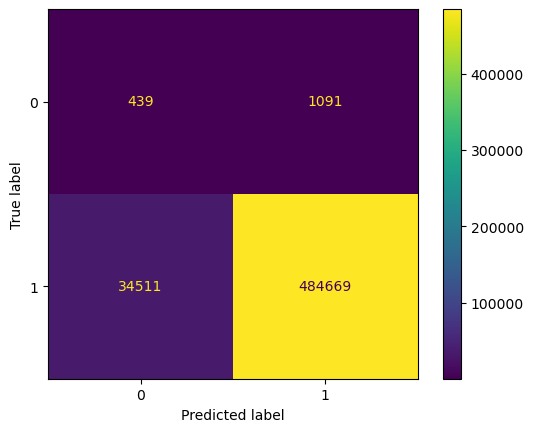

In [24]:
# Plot for visualisation
confusion_matrix = metrics.confusion_matrix(y_true_class, y_pred_class)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])
cm_display.plot()
plt.savefig("./Results/confusion60.jpg")
plt.show()